In [19]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

In [20]:
class data(Dataset):
  def __init__(self, file):
    self.file = pd.read_csv(file).to_numpy()

  def __len__(self):
     return self.file.shape[0]

  def __getitem__(self, idx):
      features = self.file[idx, :-1]
      label = self.file[idx, -1]
      return features, label

In [21]:
dataset = data("water_potability.csv")

In [22]:
import torch

In [23]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)
features, labels = next(iter(train_dataloader))

In [25]:
import torch.nn as nn
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(9, 18)
    self.fc2 = nn.Linear(18, 6)
    self.fc3 = nn.Linear(6, 1)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = nn.functional.relu(self.fc1(x))
    x = self.dropout(x)
    x = nn.functional.relu(self.fc2(x))
    x = self.dropout(x)
    x = nn.functional.sigmoid(self.fc3(x))
    return x

model = NeuralNet()

In [26]:
!pip install torchmetrics

In [27]:
from torchmetrics import Accuracy

In [31]:
import torch.optim as optim
import numpy as np

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-5)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def compute_gradients():
    gradients = []
    for param in model.parameters():
        if param.grad is not None:
            gradients.append(param.grad.norm().item())
    return gradients

gradients_history = []

for epoch in range(100):
  epoch_train_loss = 0
  model.train()
  for features, labels in train_dataloader:
    optimizer.zero_grad()
    outputs = model(features.float())
    loss = criterion(outputs, labels.float().view(-1, 1))
    loss.backward()
    gradients = compute_gradients()
    gradients_history.append(gradients)
    optimizer.step()
    epoch_train_loss += loss.item()

  avg_train_loss = epoch_train_loss / len(train_dataloader)
  train_losses.append(avg_train_loss)


  model.eval()
  epoch_val_loss = 0
  val_acc = Accuracy(task = "binary")
  with torch.no_grad():
    for features, labels in val_dataloader:
      outputs = model(features.float())
      loss = criterion(outputs, labels.float(). view(-1, 1))
      epoch_val_loss += loss.item()

      predictions = (outputs >= 0.5).float()
      val_acc(predictions, labels.float().view(-1, 1))

  avg_val_loss = epoch_val_loss / len(val_dataloader)
  val_losses.append(avg_val_loss)

  accuracy = val_acc.compute()
  val_accuracies.append(accuracy)

  print(f"Epoch: {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {accuracy}")

Epoch: 1, Training Loss: 0.6181789540355991, Validation Loss: 0.602209550730976, Validation Accuracy: 0.7096773982048035
Epoch: 2, Training Loss: 0.6165598574447335, Validation Loss: 0.5987106480716188, Validation Accuracy: 0.707196056842804
Epoch: 3, Training Loss: 0.624008087638002, Validation Loss: 0.6027783953849181, Validation Accuracy: 0.6972704529762268
Epoch: 4, Training Loss: 0.6111960361092728, Validation Loss: 0.5994799505045385, Validation Accuracy: 0.6972704529762268
Epoch: 5, Training Loss: 0.6251616010569637, Validation Loss: 0.6013566167266281, Validation Accuracy: 0.692307710647583
Epoch: 6, Training Loss: 0.6153278647002226, Validation Loss: 0.6060892317766025, Validation Accuracy: 0.7047146558761597
Epoch: 7, Training Loss: 0.6214554654145092, Validation Loss: 0.6061338193622636, Validation Accuracy: 0.6898263096809387
Epoch: 8, Training Loss: 0.6118557580879757, Validation Loss: 0.5984946150838593, Validation Accuracy: 0.7022332549095154
Epoch: 9, Training Loss: 0.6

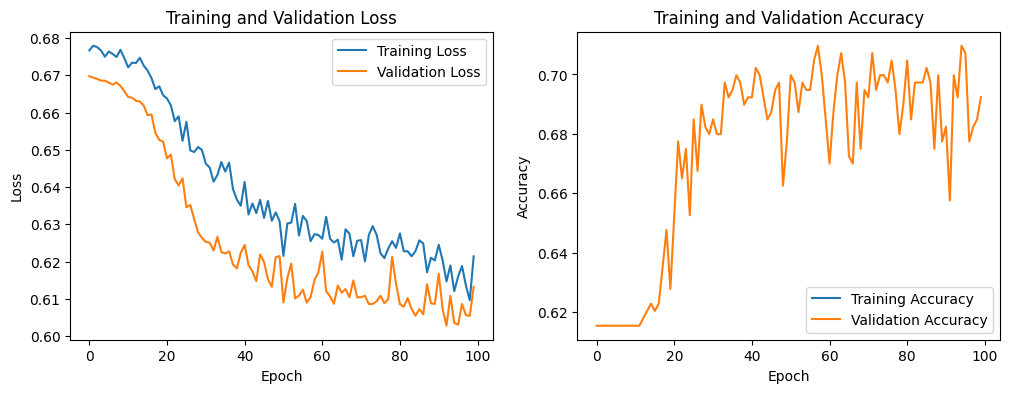

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


*  Both graphs show that the model is improving over time, with losses decreasing and accuracies increasing.

*  The fluctuations in the validation loss and accuracy are normal. They indicate how the model is handling different validation samples. A small amount of fluctuation is expected.

*  The close alignment between training and validation metrics means the model is generalizing well and is not overfitting. Overfitting would be evident if the training loss kept decreasing while the validation loss increased significantly.

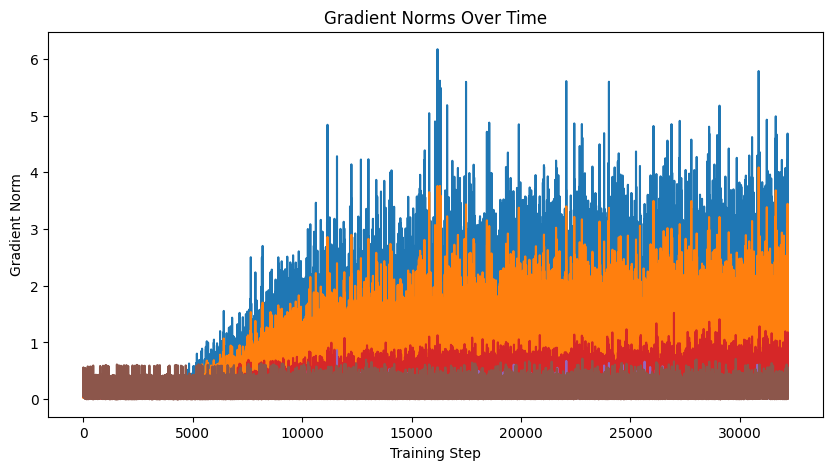

In [30]:
# Plot gradient norms
plt.figure(figsize=(10, 5))
plt.plot(gradients_history)
plt.title('Gradient Norms Over Time')
plt.xlabel('Training Step')
plt.ylabel('Gradient Norm')
plt.show()

The visualization does not indicate vanishing or exploding gradients at this point